In [1]:
#Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

### Dados

In [2]:
#Dataset
df=pd.read_excel('teste_smarkio_lbs.xls', sheet_name = 'Análise_ML')
df.head(10)

,Pred_class,probabilidade,status,True_class
0,2,0.079892,approved,0.0
1,2,0.379377,approved,74.0
2,2,0.379377,approved,74.0
3,2,0.420930,approved,74.0
4,2,0.607437,approved,NaN
5,2,0.690894,approved,NaN
6,2,0.759493,approved,NaN
7,2,0.834910,approved,NaN
8,2,0.861396,approved,NaN
9,2,1.000000,approved,NaN


### Checando os missings

In [3]:
df.isna().sum()

Pred_class         0
probabilidade      0
status             0
True_class       462
dtype: int64

### Substituindo os missings da True_class pelos valores de Pred_class

In [4]:
df['True_class'].fillna(df['Pred_class'],inplace=True)

In [5]:
# Convertendo True_class para int
df['True_class']=df['True_class'].astype('int32')
df.head(10)

,Pred_class,probabilidade,status,True_class
0,2,0.079892,approved,0
1,2,0.379377,approved,74
2,2,0.379377,approved,74
3,2,0.420930,approved,74
4,2,0.607437,approved,2
5,2,0.690894,approved,2
6,2,0.759493,approved,2
7,2,0.834910,approved,2
8,2,0.861396,approved,2
9,2,1.000000,approved,2


# 1. Análise exploratória dos dados utilizando estatística descritiva e inferencial, considerando uma, duas e/ou mais variáveis;

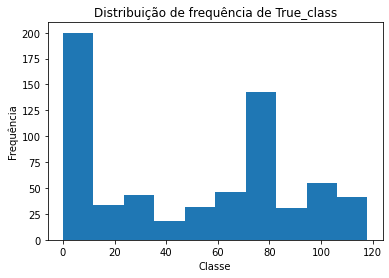

In [6]:
# Histograma para a classe True_class
df['True_class'].hist()
plt.title('Distribuição de frequência de True_class')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.grid(b=None)
plt.show()

### Proporção de approved e revision para status


In [7]:
n=df.shape[0]
freq={'Freq':df['status'].value_counts(),
        'Freq(%)':df['status'].value_counts()/n}
tbl_status=pd.DataFrame(freq)
tbl_status['Freq(%)'] = tbl_status['Freq(%)'].astype(float).map("{:.2%}".format)
tbl_status

,Freq,Freq(%)
approved,600,93.31%
revision,43,6.69%


### Visualização


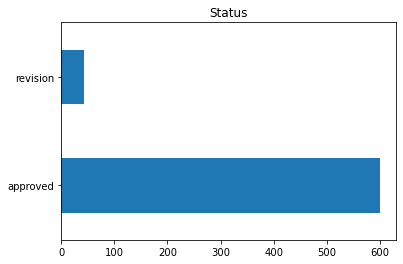

In [8]:
df['status'].value_counts().plot.barh()
plt.title('Status')
plt.show()

### Probabilidade x status


##### Bloxplot


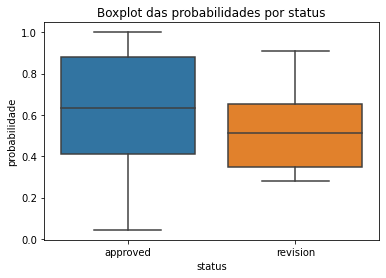

In [9]:
sns.boxplot(x=df['status'], y=df['probabilidade'], orient='v')
plt.title('Boxplot das probabilidades por status')
plt.show()

##### Teste t
Execução do teste t para testar se há diferença entre a média das probabilidades dos dois grupos (approved e revision)


In [10]:
approved=df['probabilidade'][df['status']=='approved']
revision=df['probabilidade'][df['status']=='revision']

In [11]:
## Execução do teste
ttest_ind(approved,revision)

Ttest_indResult(statistic=2.5358689388146742, pvalue=0.011453227726784192)

> Conclusão do teste: Com 95% de confiança, há evidência estatística de que há diferença entre as médias das probabilidades dos grupos 'approved' e 'revision'.

# 2. Calcule o desempenho do modelo de classificação utilizando pelo menos três métricas;

In [12]:
target=df['True_class'].astype('string')
pred=df['Pred_class'].astype('string')

In [13]:
accuracy=accuracy_score(target, pred)
precision=precision_score(target, pred, average='macro', zero_division=1)
recall=recall_score(target, pred, average='macro', zero_division=1)
f1=f1_score(target, pred, average='macro', zero_division=1)

In [23]:
pd.DataFrame({'Métricas':np.round([accuracy,precision,recall,f1],2)}, 
            index=['Acurácia','Precisão','Recall','F1'])

,Métricas
Acurácia,0.72
Precisão,0.65
Recall,0.81
F1,0.64


# 3. Crie um classificador que tenha como output se os dados com status igual a revision estão corretos ou não (Sugestão : Técnica de cross-validation K-fold);

O classificador usado será o Random Forest. Como o interesse é saber se os dados da classe positiva estão classificados corretamente, a métrica apropriada é o recall.

In [15]:
target=df['status'].values
target=np.where(target=='revision',1,0)
attr=df.drop('status', axis=1).values

In [16]:
classifier=RandomForestClassifier(n_estimators=11, random_state=111)

In [17]:
cvs_recall=cross_val_score(classifier, attr, target, scoring='recall', cv=10)

In [18]:
print('Resultados do cross validation:')
pd.DataFrame({'Recall': cvs_recall})

Resultados do cross validation:


,Recall
0,0.20
1,0.20
2,0.00
3,0.25
4,0.00
5,0.00
6,0.50
7,0.00
8,0.25
9,0.00


In [19]:
print("Média por fold: " + str(round(cvs_recall.mean(),2)))

Média por fold: 0.14


# 4. Compare três métricas de avaliação aplicadas ao modelo e descreva sobre a diferença;

In [20]:
cvs_recall=cross_val_score(classifier, attr, target, scoring='recall', cv=10)
cvs_accuracy=cross_val_score(classifier, attr, target, scoring='accuracy', cv=10)
cvs_precision=cross_val_score(classifier, attr, target, scoring='precision', cv=10)

In [21]:
print('Cross validation para acurácia, precisão e recall')
pd.DataFrame({'Acurácia':np.round(cvs_accuracy,2),
              'Precisão':np.round(cvs_precision,2),
              'Recall': np.round(cvs_recall,2)})

Cross validation para acurácia, precisão e recall


,Acurácia,Precisão,Recall
0,0.91,0.33,0.20
1,0.89,0.25,0.20
2,0.88,0.00,0.00
3,0.95,1.00,0.25
4,0.81,0.00,0.00
5,0.94,0.00,0.00
6,0.95,0.67,0.50
7,0.91,0.00,0.00
8,0.95,1.00,0.25
9,0.92,0.00,0.00


In [22]:
print("Acurácia média: " + str(round(cvs_accuracy.mean(),2)))
print("Precisão média: " + str(round(cvs_precision.mean(),2)))
print("Recall médio: " + str(round(cvs_recall.mean(),2)))

Acurácia média: 0.91
Precisão média: 0.32
Recall médio: 0.14


+ A acurácia mede a proporção de classificações corretas do modelo. Para cada fold, o modelo acertou, em média, 91% das classificações. 
+ A precisão mede a proporção de acertos que o modelo teve para a classe positiva; como exemplo, no primeiro fold, o modelo acertou 33% das observações que classificou como "revision".
+ O recall mede a proporção de observações da classe positiva que foram classificadas corretamente. Também no primeiro fold, 20% dos dados de treino com status "revision" foram classificados corretamente pelo modelo.